### *CIFAR-10 with CNN*

##### Problem Statement

This is a classification problem with 10 classes(muti-label classification). The dataset for this task is the CIFAR-10. Each class contains 6,000 images which makes up 60,000 color images in the dataset. The training set contains 50,000 images, while the test sets provides 10,000 images. Link to the dataset: https://www.cs.toronto.edu/~kriz/cifar.html

##### Load Libraries dataset

In [6]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

#Hyperparameters
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

%matplotlib inline

In [5]:
print(tf.__version__)

2.13.0


##### Import dataset

In [10]:
# The data, split between train and test sets:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


c:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


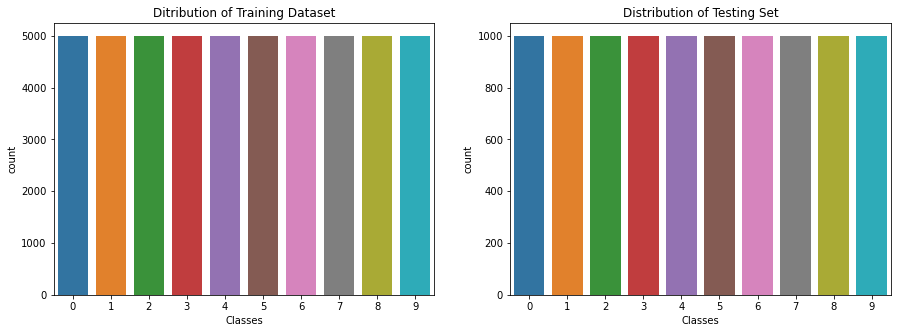

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
#Distribution of Training Set
sns.countplot(y_train.ravel(), ax= axs[0])
axs[0].set_title("Ditribution of Training Dataset")
axs[0].set_xlabel("Classes")
#Count Plot for testing Set
sns.countplot(y_test.ravel(), ax = axs[1])
axs[1].set_title("Distribution of Testing Set")
axs[1].set_xlabel("Classes")
plt.show()

In [16]:
#Normalize data to improve training time

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [17]:
#Define a convolution net

model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3,3), padding = 'same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

##### Model Training

In [19]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/100
1563/1563 [==============================] - 171s 108ms/step - loss: 1.8571 - accuracy: 0.3241 - val_loss: 1.5740 - val_accuracy: 0.4369
Epoch 2/100
1563/1563 [==============================] - 145s 93ms/step - loss: 1.5214 - accuracy: 0.4501 - val_loss: 1.4194 - val_accuracy: 0.4957
Epoch 3/100
1563/1563 [==============================] - 130s 83ms/step - loss: 1.3885 - accuracy: 0.5000 - val_loss: 1.3188 - val_accuracy: 0.5304
Epoch 4/100
1563/1563 [==============================] - 134s 86ms/step - loss: 1.2902 - accuracy: 0.5407 - val_loss: 1.2123 - val_accuracy: 0.5767
Epoch 5/100
1563/1563 [==============================] - 136s 87ms/step - loss: 1.2070 - accuracy: 0.5740 - val_loss: 1.0932 - val_accuracy: 0.6194
Epoch 6/100
1563/1563 [==============================] - 134s 86ms/step - loss: 1.1368 - accuracy: 0.5997 - val_loss: 1.0664 - val_accuracy: 0.6245
Epoch 7/100
1563/1563 [==============================] - 138s 88ms/step - loss: 1.